# Description

This notebook is for Jeremy Howard lesson 1 code in Kaggle.

Link: [Notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data)

In [1]:
#This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.

!pip install fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 1.9 MB/s eta 0:00:002.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.2 MB/s eta 0:00:002.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.2 MB/s eta 0:00:002.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 1: Download images of birds and non-birds

In [16]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [17]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

...and then download a URL and take a look at it:

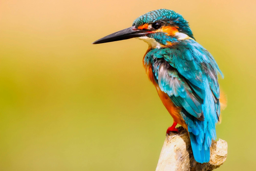

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


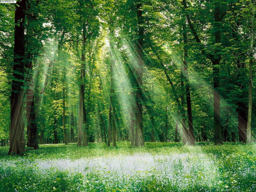

In [8]:
urls = search_images('forest photos', max_images=1)
dest = 'forest.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

### Build a dataset to train the model

Let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [9]:
!mkdir bird_or_not

In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    print(f"Downloading {o} images")
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

### Create a dataloader

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

### Argument description:

- `blocks`: Represent the input and output block types. In the below case, inputs are images and outputs are categories aka labels.
- `get_items`: We use the function `get_image_files` in `fastai` to get the image.
- `splitter`: Define a train-val split for the training phase. In the below case, we use a `RandomSplitter`
- `get_y`: Get the actual label names. In this case, it will take the parent folder name.
- `item_tfms`: These are item transformations we use to do some preprocessing of the inputs. In a CV example, we might need to resize all images to the same size. In the below case we *squish* the images to $192*192$

Finally we create the `dataloader` which PyTorch actually uses to iterate over the instances.

**Reference**: [Docs](https://docs.fast.ai/tutorial.datablock.html)

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

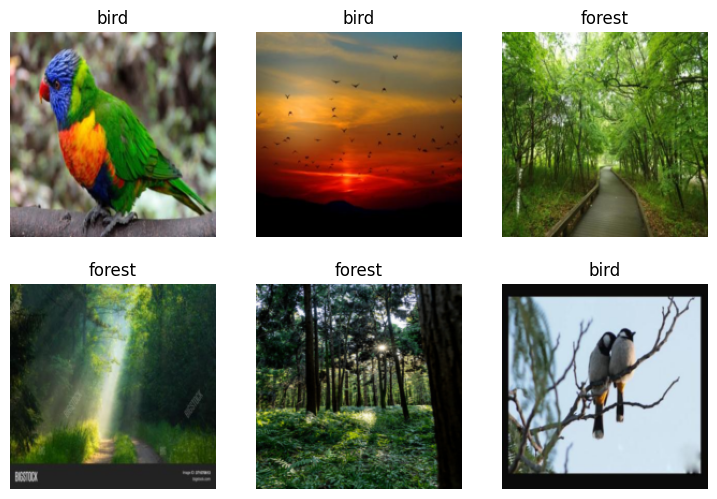

In [13]:
dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

### Train a NN model

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

#### References:
- `timm`: Largest collection of pretrained image models [link](https://timm.fast.ai/)
- **Image classification tutorial**: [Link](https://docs.fast.ai/tutorial.vision.html)

In [18]:
!mv resnet18-f37072fd.pth /Users/sohammistri/.cache/torch/hub/checkpoints/

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.209741,0.207346,0.090909,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.175631,0.098097,0.060606,00:01
1,0.102190,0.042150,0.030303,00:00
2,0.072936,0.036390,0.030303,00:00


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [20]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9997
